# Logistic Regression with Hyperparameter Tuning
Trying to improve the model by tuning C and penalty parameters

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

In [2]:
# Load the data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_1.csv')

print(train.shape)
print(test.shape)

(159571, 8)
(63978, 8)


In [3]:
# Labels we need to predict
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
# Create TF-IDF features - same as before
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train['comment_text'])
X_test = vectorizer.transform(test['comment_text'])

print(f"Features: {X_train.shape}")

Features: (159571, 10000)


## Grid Search for Tuning
Going to try different C values and penalty types (l1 vs l2)

In [5]:
# Parameter grid to search
# C controls regularization - smaller C = more regularization
# penalty can be l1 or l2
param_grid = [
    {'C': [0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear'], 'class_weight': ['balanced'], 'max_iter': [200]},
    {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear'], 'class_weight': ['balanced'], 'max_iter': [200]}
]

In [6]:
# Train models with grid search
models = {}
best_params = {}

for label in labels:
    print(f"\nTuning {label}...")
    
    y_train = train[label]
    
    # Use GridSearchCV to find best parameters
    lr = LogisticRegression()
    grid = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    models[label] = grid.best_estimator_
    best_params[label] = grid.best_params_
    
    print(f"Best params: C={grid.best_params_['C']}, penalty={grid.best_params_['penalty']}")
    print(f"Best CV score: {grid.best_score_:.4f}")


Tuning toxic...
Best params: C=1, penalty=l2
Best CV score: 0.9631

Tuning severe_toxic...
Best params: C=0.1, penalty=l2
Best CV score: 0.9823

Tuning obscene...
Best params: C=0.1, penalty=l1
Best CV score: 0.9760

Tuning threat...
Best params: C=1, penalty=l2
Best CV score: 0.9868

Tuning insult...
Best params: C=1, penalty=l2
Best CV score: 0.9709

Tuning identity_hate...
Best params: C=0.1, penalty=l2
Best CV score: 0.9669


In [7]:
# Make predictions
predictions = {}
pred_proba = {}

for label in labels:
    predictions[label] = models[label].predict(X_test)
    pred_proba[label] = models[label].predict_proba(X_test)[:, 1]

## Calculate Metrics
Using macro-precision, macro-recall, macro-f1, and AUC-PR

In [8]:
# Calculate all the metrics
results = []

for label in labels:
    y_true = test[label]
    y_pred = predictions[label]
    y_proba = pred_proba[label]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_true, y_proba)
    auc_pr = average_precision_score(y_true, y_proba)  # This is AUC-PR
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    results.append({
        'label': label,
        'roc_auc': roc_auc,
        'auc_pr': auc_pr,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'best_C': best_params[label]['C'],
        'best_penalty': best_params[label]['penalty']
    })

results_df = pd.DataFrame(results)
print(results_df)

           label   roc_auc    auc_pr  macro_precision  macro_recall  macro_f1  \
0          toxic  0.945602  0.729129         0.699991      0.874223  0.743540   
1   severe_toxic  0.981749  0.298554         0.547565      0.930226  0.573721   
2        obscene  0.959870  0.742806         0.699364      0.898513  0.755565   
3         threat  0.986342  0.312321         0.586273      0.905806  0.639668   
4         insult  0.955352  0.677937         0.676698      0.887846  0.730445   
5  identity_hate  0.965228  0.420141         0.564806      0.900355  0.596918   

   best_C best_penalty  
0     1.0           l2  
1     0.1           l2  
2     0.1           l1  
3     1.0           l2  
4     1.0           l2  
5     0.1           l2  


In [9]:
# Print averages
print("\nAverage scores:")
print(f"ROC-AUC: {results_df['roc_auc'].mean():.4f}")
print(f"AUC-PR: {results_df['auc_pr'].mean():.4f}")
print(f"Macro Precision: {results_df['macro_precision'].mean():.4f}")
print(f"Macro Recall: {results_df['macro_recall'].mean():.4f}")
print(f"Macro F1: {results_df['macro_f1'].mean():.4f}")


Average scores:
ROC-AUC: 0.9657
AUC-PR: 0.5301
Macro Precision: 0.6291
Macro Recall: 0.8995
Macro F1: 0.6733


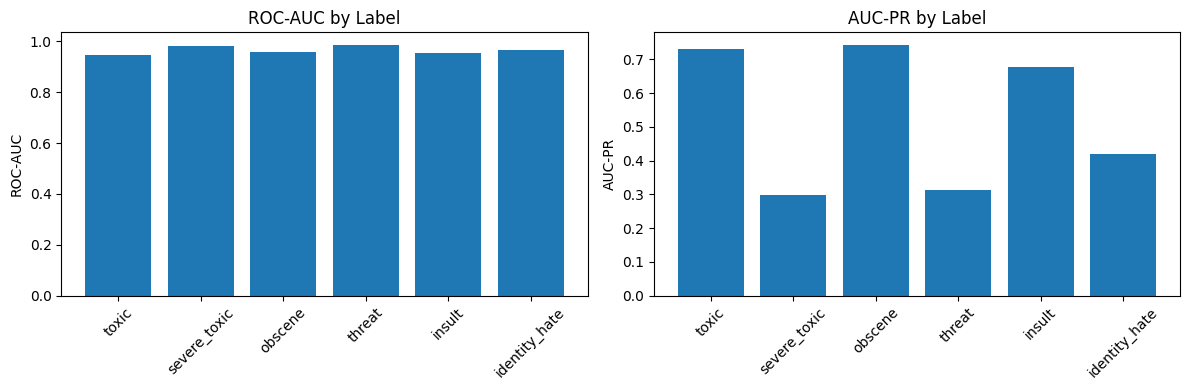

In [10]:
# Simple plot to visualize results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# ROC-AUC
ax[0].bar(results_df['label'], results_df['roc_auc'])
ax[0].set_title('ROC-AUC by Label')
ax[0].set_ylabel('ROC-AUC')
ax[0].tick_params(axis='x', rotation=45)

# AUC-PR
ax[1].bar(results_df['label'], results_df['auc_pr'])
ax[1].set_title('AUC-PR by Label')
ax[1].set_ylabel('AUC-PR')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Save results
results_df.to_csv('../results/logistic_regression_tuned_results.csv', index=False)
print("Saved results!")

Saved results!


In [12]:
# Compare with baseline model if it exists
try:
    baseline = pd.read_csv('../results/logistic_regression_results.csv')
    print("\nComparison with baseline:")
    print(f"Baseline avg ROC-AUC: {baseline['roc_auc'].mean():.4f}")
    print(f"Tuned avg ROC-AUC: {results_df['roc_auc'].mean():.4f}")
    print(f"Difference: {results_df['roc_auc'].mean() - baseline['roc_auc'].mean():.4f}")
except:
    print("No baseline to compare")


Comparison with baseline:
Baseline avg ROC-AUC: 0.9650
Tuned avg ROC-AUC: 0.9657
Difference: 0.0007
